In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os 

GPUID='2'
os.environ['CUDA_VISIBLE_DEVICES']=GPUID

In [3]:
import sys
import datetime
import uuid
#export
import time
#pip3 install psutil
import psutil
from exp.nb_formatted import *

In [4]:
torch.cuda.empty_cache()

In [5]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

In [6]:
#set to true on first run
RETRAIN=False
#max mem use for weights in GB in RAM:
MAX_MEM=40

In [7]:
pid = os.getpid()
py = psutil.Process(pid)
memoryUse = py.memory_info()[0] / 2. ** 30
print('memory use:', memoryUse)

memory use: 2.3794021606445312


In [8]:
#base, shallow, deep
HOOK_DEPTH = 'shallow'
CURRENT_DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
NAME=HOOK_DEPTH+'_'+CURRENT_DATE+'_'+UID+'_'+GPUID

In [9]:
cwd=os.getcwd()
IMG_PATH=os.path.abspath(cwd + "/images/")

In [10]:
IMG_PATH

'/mnt/963GB/Data/Python/Courses/my_fastai/2019_pt2_dev_course/dl2/images'

## Serializing the model

Store on ssd rather than in home folder

In [11]:
path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160, dest='data')

In [12]:
size = 128
bs = 64
#bs = 512

tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]
val_tfms = [make_rgb, CenterCrop(size), np_to_float]
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
ll.valid.x.tfms = val_tfms
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

In [13]:
len(il)

12954

In [14]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

Using imagenette norm on imagewoof

In [15]:
learn = cnn_learner(arch=xresnet18, data=data, loss_func=loss_func, opt_func=opt_func, norm=norm_imagenette)

In [16]:
def sched_1cycle(lr, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [17]:
lr = 3e-3
pct_start = 0.5
cbsched = sched_1cycle(lr, pct_start)

save out model so can use with pets

1 x 2080ti, bs=256, epochs=10, elapsed: 115.17198395729065

2 x 2080ti, bs=512, epochs=10, elapsed: 79.39946436882019

In [18]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)

if RETRAIN:
    start=time.time()
    learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1, 2])
    learn.fit(500, cbsched)
    end=time.time()
    print(f'elapsed: {end-start}')
    st = learn.model.state_dict()

    print(type(st))

    #keys are names of the layers
    print(', '.join(st.keys()))
    print(path)

    #It's also possible to save the whole model, including the architecture, 
    #but it gets quite fiddly and we don't recommend it. 
    #Instead, just save the parameters, and recreate the model directly.

    #torch.save(st, mdl_path/'iw5')
else:
    print('Loading pre-trained model weights')
    learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
    st = learn.model.state_dict()
    print(st['10.bias'])

Loading pre-trained model weights
tensor([-0.0019,  0.0097, -0.0056, -0.0109,  0.0048,  0.0073, -0.0170, -0.0088,
         0.0120,  0.0037])


## Pets

In [19]:
pets = datasets.untar_data(datasets.URLs.PETS, dest='data')

In [20]:
pets.ls()

[PosixPath('data/oxford-iiit-pet/annotations'),
 PosixPath('data/oxford-iiit-pet/images')]

In [21]:
pets_path = pets/'images'

In [22]:
il = ImageList.from_files(pets_path, tfms=tfms)

In [23]:
il

ImageList (7390 items)
[PosixPath('data/oxford-iiit-pet/images/scottish_terrier_193.jpg'), PosixPath('data/oxford-iiit-pet/images/Bengal_173.jpg'), PosixPath('data/oxford-iiit-pet/images/boxer_147.jpg'), PosixPath('data/oxford-iiit-pet/images/pug_137.jpg'), PosixPath('data/oxford-iiit-pet/images/german_shorthaired_54.jpg'), PosixPath('data/oxford-iiit-pet/images/Ragdoll_88.jpg'), PosixPath('data/oxford-iiit-pet/images/english_setter_120.jpg'), PosixPath('data/oxford-iiit-pet/images/great_pyrenees_120.jpg'), PosixPath('data/oxford-iiit-pet/images/British_Shorthair_212.jpg'), PosixPath('data/oxford-iiit-pet/images/leonberger_155.jpg')...]
Path: data/oxford-iiit-pet/images

We dont have a sapratae validation directory so randomly grab val samples

In [24]:
#export
def random_splitter(fn, p_valid): return random.random() < p_valid

In [25]:
random.seed(42)

In [26]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))

In [27]:
sd

SplitData
Train: ImageList (6667 items)
[PosixPath('data/oxford-iiit-pet/images/scottish_terrier_193.jpg'), PosixPath('data/oxford-iiit-pet/images/boxer_147.jpg'), PosixPath('data/oxford-iiit-pet/images/pug_137.jpg'), PosixPath('data/oxford-iiit-pet/images/german_shorthaired_54.jpg'), PosixPath('data/oxford-iiit-pet/images/Ragdoll_88.jpg'), PosixPath('data/oxford-iiit-pet/images/english_setter_120.jpg'), PosixPath('data/oxford-iiit-pet/images/British_Shorthair_212.jpg'), PosixPath('data/oxford-iiit-pet/images/chihuahua_132.jpg'), PosixPath('data/oxford-iiit-pet/images/staffordshire_bull_terrier_59.jpg'), PosixPath('data/oxford-iiit-pet/images/chihuahua_127.jpg')...]
Path: data/oxford-iiit-pet/images
Valid: ImageList (723 items)
[PosixPath('data/oxford-iiit-pet/images/Bengal_173.jpg'), PosixPath('data/oxford-iiit-pet/images/great_pyrenees_120.jpg'), PosixPath('data/oxford-iiit-pet/images/leonberger_155.jpg'), PosixPath('data/oxford-iiit-pet/images/Siamese_84.jpg'), PosixPath('data/oxfor

Now need to label - use filenames as cant use folders

In [28]:
n = il.items[0].name; n

'scottish_terrier_193.jpg'

In [29]:
re.findall(r'^(.*)_\d+.jpg$', n)[0]

'scottish_terrier'

In [30]:
def pet_labeler(fn): 
    return re.findall(r'^(.*)_\d+.jpg$', fn.name)[0]

Use CategoryProcessor from last week

In [31]:
proc = CategoryProcessor()

In [32]:
ll = label_by_func(sd, pet_labeler, proc_y=proc)

In [33]:
', '.join(proc.vocab)

'scottish_terrier, boxer, pug, german_shorthaired, Ragdoll, english_setter, British_Shorthair, chihuahua, staffordshire_bull_terrier, Maine_Coon, pomeranian, american_pit_bull_terrier, yorkshire_terrier, Bengal, saint_bernard, Birman, Abyssinian, Bombay, Siamese, keeshond, beagle, american_bulldog, shiba_inu, wheaten_terrier, leonberger, basset_hound, great_pyrenees, japanese_chin, Russian_Blue, Sphynx, havanese, Egyptian_Mau, english_cocker_spaniel, samoyed, newfoundland, miniature_pinscher, Persian'

In [34]:
ll.valid.x.tfms = val_tfms

In [35]:
c_out = len(proc.vocab)

In [36]:
data = ll.to_databunch(bs, c_in=3, c_out=c_out, num_workers=8)

In [37]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, norm=norm_imagenette)

In [38]:
if RETRAIN:
    learn.fit(5, cbsched)

<pre>
epoch 	train_loss 	train_accuracy 	valid_loss 	valid_accuracy 	time
0 	3.467661 	0.083246 	3.488343 	0.095436 	00:07
1 	3.303485 	0.126594 	3.571582 	0.112033 	00:07
2 	3.123925 	0.179691 	3.204137 	0.159059 	00:07
3 	2.826835 	0.265037 	2.929686 	0.250346 	00:07
4 	2.544567 	0.360582 	2.638438 	0.355463 	00:07
</pre>

## Custom head

Poor result above, here we read in imagewoof model and customise for pets. Create 10 activations at end.

Also addpend Recorder callback to access loss

In [39]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)

In [40]:
mdl_path

PosixPath('data/imagewoof-160/models')

In [41]:
st = torch.load(mdl_path/'iw5')

In [42]:
st.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [43]:
m = learn.model

In [44]:
mst = m.state_dict()

In [45]:
mst.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [46]:
#check that keys are same in both dicts

In [47]:
[k for k in st.keys() if k not in mst.keys()]

[]

In [48]:
m.load_state_dict(st)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [49]:
#want to remove last layer as have different ammount of categries - here 37 pet breeds. Find the AdaptiveAvgPool2d layer and use everything before this

In [50]:
m

XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [51]:
cut = next(i for i,o in enumerate(m.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
m_cut = m[:cut]

In [52]:
len(m_cut)

8

In [53]:
def module_grandchildren(model):
    grandkids=[]
    for m in m_cut.children():
        for g in m.children():
            grandkids.append(g)
    return grandkids

In [54]:
m_gc = module_grandchildren(m_cut)

In [55]:
xb,yb = get_batch(data.valid_dl, learn)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [56]:
pred = m_cut(xb)

In [57]:
pred.shape

torch.Size([128, 512, 4, 4])

To find number of inputs, here we have 128 minibatch of input size 512, 4x4

In [58]:
#number of inputs to our head
ni = pred.shape[1]

Note we use both Avg and Max pool and concatenate them together eg
https://www.cs.cmu.edu/~tzhi/publications/ICIP2016_two_stage.pdf

In [59]:
#export
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [60]:
nh = 40

#### stat and plot functions

histc()

Computes the histogram of a tensor.
        
        The elements are sorted into equal width bins between :attr:`min` and
        :attr:`max`. If :attr:`min` and :attr:`max` are both zero, the minimum and
        maximum values of the data are used.

In [61]:
#create a global in the __main__ scope so we can track iterations
stat_iter = 0

In [62]:
#as per lecture but with relu scale check
def append_hist_stats(hook, mod, inp, outp):
    global stat_iter
    memoryUse=0
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    #mod 0 is XResNet object with properties:
    #_backend, _backward_hooks,_buffers,_forward_hooks (this is where stats is located)
    #,_load_state_dict_pre_hooks,_modules (87 sequentiol, 1 MaxPool2d)
    #,_parameters,_state_dict_hooks
    #then 1 AdaptiveConcatPool2d
    #then 2 Flatten
    #then 3 Linear (with shape [64,37])
    if mod.training:
        #eg outp.data shape is [64,512,4,4]
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        if isinstance(mod, nn.Linear):
            hists.append(outp.data.cpu().histc(40,-10,10)) #no relu here
        else:
            hists.append(outp.data.cpu().histc(40,0,10)) #no negatives
        if stat_iter<100:
            print(f'iter: {stat_iter}, layer: {mod.__class__.__name__}, data shape: {outp.data.cpu().numpy().shape}')
        stat_iter+=1

In [63]:
#this is run on each batch
def append_hist_delta_stats(hook, mod, inp, outp):
    global stat_iter
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    #keep previous batch data for calculating deltas
    if not hasattr(hook,'prevdatas'): 
        hook.prevdatas = ([])
    if not hasattr(hook,'hdeltas'): 
        hook.hdeltas = ([])
    means,stds,hists = hook.stats
    prevdata=hook.prevdatas
    deltas = hook.hdeltas
    if mod.training:
        #eg outp.data shape is [64,512,4,4]
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        if len(prevdata)>0:
            try:
                delta=outp.data.cpu()-prevdata[0]
            except RuntimeError as e:
                #problem at end of batch when size of prev wont match current
                delta=outp.data.cpu()
        else:
            delta=outp.data.cpu()
        prevdata.append(outp.data.cpu())
        if len(prevdata)>1:
            #just keep the last one otherwise will overrun memory
            prevdata=prevdata[-1]
        deltas.append(delta.histc(40,-10,10))
        if isinstance(mod, nn.Linear):
            hists.append(outp.data.cpu().histc(40,-10,10)) #no relu here
        else:
            hists.append(outp.data.cpu().histc(40,0,10)) #no negatives
        stat_iter+=1

In [64]:

#needs work before can use - far too much data to store without downsampling
def append_raw_hist_stats(hook, mod, inp, outp):
    global stat_iter
    memoryUse=0
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    if not hasattr(hook,'raws'): 
        hook.raws = ([])
    means,stds,hists = hook.stats
    raws = hook.raws
    if mod.training:
        #eg outp.data shape is [64,512,4,4]
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        if (stat_iter % 100) == 0:
            memoryUse = py.memory_info()[0] / 2. ** 30
        if memoryUse < MAX_MEM:
            d = outp.data
            if len(outp.data.shape)==4:
                new_shape=outp.data.shape
                #want 3 channels so can plot r,g,b
                new_shape[-1]=3
                #put channel as last dimension
                d=d.permute(0, 2, 3, 1)
                d=d.cpu().numpy()
                #calc mean of the whole batch
                d=d.mean(0)
                #now coerce to 3 channels
                d=bin_ndarray(d, new_shape, operation='mean')
            #flatten and linear are dim 2 
            #now take mean over last index to reduce size
            else:
                d=d.cpu().numpy()
            raws.append(d.mean(-1))
            if stat_iter==0:
                print(f'data shape: {outp.data.cpu().numpy().shape}, size: {outp.data.cpu().numpy().size}, mean size: {outp.data.cpu().numpy().mean(-1).size}')
        else:
            print(f'oom appending: {outp.data.cpu().numpy().mean(-1).size}, {outp.data.cpu().numpy().shape}')
        if isinstance(mod, nn.Linear):
            hists.append(outp.data.cpu().histc(40,-10,10)) #no relu here
        else:
            hists.append(outp.data.cpu().histc(40,0,10)) #no negatives
        if stat_iter<100:
            print(f'iter: {stat_iter}, layer: {mod.__class__.__name__}, data shape: {outp.data.cpu().numpy().shape}')
        stat_iter+=1

In [65]:
def plot_hooks(hooks, model, fig_name=None):
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    print(f'plotting {len(hooks)} layers')
    i=0
    first_len=0
    for h,m in zip(hooks,model):
        ms,ss, hists = h.stats
        if i==0:
            first_len=len(ms)
        #print(f"{i}, {str(m).split('(')[0]}: {len(ms)}")
        if str(m).split('(')[0]=='ReLU':
        #data for Relu layer is 19 times longer than other layers, not sure why
            ms=ms[:first_len] 
            ss=ss[:first_len] 
        ax0.plot(ms)
        ax0.set_title('mean')
        ax1.plot(ss)
        ax1.set_title('std. dev.')
        i+=1
    if model:   
        titles=[]
        idxs=[]
        for j,m in enumerate(learn.model):
            titles.append(str(j)+' '+str(m).split('(')[0])
        plt.legend(titles)
    else:
        plt.legend(range(len(hooks)))
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [66]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [67]:
def plot_deltas(deltas, smoother, fig_name=None):
    half_plots=int((len(deltas)/2) + (len(deltas)/2 % 1 > 0))
    fig,axes= plt.subplots(half_plots,2, figsize=(10,half_plots*2))
    for ax,h in zip(axes.flatten(), deltas):
        h = smooth(h, smoother)
        ax.plot(h)
        ax.set_title('delta')
    plt.legend(range(len(deltas)))
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [68]:
#get the hist data at index 2
def get_hist(h): 
    assert len(h.stats)==3
    return torch.stack(h.stats[2]).t().float().log1p().cpu()

In [69]:
def get_delta_hist(h): 
    return torch.stack(h.hdeltas).t().float().log1p().cpu()

In [70]:
def plot_hooks_hist(hooks, fig_name=None, model=None):
    #subplots(rows,colums)
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*3))
    i=0
    for ax,h in zip(axes.flatten(), hooks):
        ax.imshow(get_hist(h), origin='lower')
        ax.imshow(get_hist(h))
        ax.set_aspect('auto')
        ax.axis('on')
        if model:
            for j,m in enumerate(learn.model):
                if i == j:
                    title=str(m).split('(')[0]
                    ax.set_title(title)
        i+=1
    plt.tight_layout()
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [71]:
def plot_hooks_delta_hist(hooks, fig_name=None,model=None):
    #subplots(rows,colums)
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*3))
    i=0
    for ax,h in zip(axes.flatten(), hooks):
        ax.imshow(get_delta_hist(h), origin='lower')
        ax.imshow(get_delta_hist(h))
        ax.set_aspect('auto')
        ax.axis('on')
        if model:
            for j,m in enumerate(learn.model):
                if i == j:
                    title=str(m).split('(')[0]
                    ax.set_title(title)
        i+=1
    plt.tight_layout()
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [72]:
def plot_hooks_hist_lines(hooks, fig_name=None):
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*5))
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_hist(h))
        ax.axis('on')
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [73]:
def get_start_mins(h):
    h1 = torch.stack(h.stats[2]).t().float().cpu()
    return h1[:2].sum(0)/h1.sum(0)

In [74]:
def get_mid_mins(h, max_hist):
    h1 = torch.stack(h.stats[2]).t().float().cpu()
    #get stats on middle bins of histogram data
    return h1[int((max_hist/2)-1):int((max_hist/2)+2)].sum(0)/h1.sum(0)

In [75]:
def plot_mins(hooks):
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*2))
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_start_mins(h))
        ax.set_ylim(0,1)
        ax.axis('on')
    plt.tight_layout()
    plt.legend(['start'])

In [76]:
def plot_mid_mins(hooks):
    half_plots=int((len(hooks)/2) + (len(hooks)/2 % 1 > 0))
    fig,axes = plt.subplots(half_plots,2, figsize=(15,int(len(hooks)/2)*2))
    hist = get_hist(hooks[0])
    max_hist=hist.shape[0]
    print(max_hist)
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_mid_mins(h,max_hist))
        ax.set_ylim(-1,1)
        ax.axis('on')
    plt.tight_layout()
    plt.legend(['mid'])

In [77]:
def plot_ep_vals(ep_vals, fig_name=None):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
    if fig_name:
        plt.savefig(IMG_PATH+'/'+NAME+'_'+fig_name)
    plt.show()

In [78]:
def plot_raw_layers(hooks):
    for h in hooks:
        print(len(h.raws))
        h_raw_np=np.concatenate(h.raws, axis=0 )
        plot_kernels(h_raw_np)

In [79]:
#after Fchaubard https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/7
def plot_kernels(tensor, num_cols=6):
    if isinstance(tensor, list):
        print(len(tensor))
        print(tensor[0].shape)
    if not tensor.ndim==4:
        #not plotting Flatten or Linear layers
        return
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [80]:
for i,m in enumerate(learn.model):
    print(f'i: {i}, model part: {m}')

i: 0, model part: Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
i: 1, model part: Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
i: 2, model part: Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
i: 3, model part: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
i: 4, model part: Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

#### Model change

Allow hook to access internals of XResNet by unpacking arg list

In [81]:
m_new = nn.Sequential(
    *m_cut.children(), AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [82]:
m_new_deep = nn.Sequential(
    *m_gc, AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [83]:
m_new_shallow = nn.Sequential(
    m_cut, AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [84]:
if HOOK_DEPTH=='deep':
    learn.model = m_new_deep
elif HOOK_DEPTH=='base':
    learn.model = m_new
elif HOOK_DEPTH=='shallow':
    learn.model = m_new_shallow

In [85]:
len(learn.model)

4

When we ran telemetry previously in lesson 10 (nb 06), were were using a manually built model with 7 layers:

<pre>
    Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)
</pre>

Like the code below the AdaptiveAvgPool2d and Lambda (below we use Flatten) have the same output data-ie same plot

### Fit

[batch_size, channels, height, width]

In [86]:
#with Hooks(learn.model, append_hist_stats) as hooks_basic_naive: 
#    learn.fit(1, cbsched)

In [87]:
stat_iter = 0

In [88]:
#5
with Hooks(learn.model, append_hist_delta_stats) as hooks_naive: 
    learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.806777,0.301335,2.425002,0.396957,00:08
1,2.160112,0.475326,2.809568,0.312586,00:08
2,2.046233,0.517924,2.484398,0.387275,00:08
3,1.758707,0.625019,1.746427,0.621024,00:08
4,1.484720,0.733013,1.569671,0.701245,00:09


In [89]:
print(f'iteration: {stat_iter}')

iteration: 2100


<pre>
epoch 	train_loss 	train_accuracy 	valid_loss 	valid_accuracy 	time
0 	2.852017 	0.287686 	2.486142 	0.387275 	00:08
1 	2.179299 	0.469177 	2.641399 	0.352697 	00:07
2 	2.030308 	0.531273 	2.449481 	0.413555 	00:07
3 	1.731837 	0.638368 	1.788130 	0.615491 	00:07
4 	1.465440 	0.747413 	1.599652 	0.690180 	00:07
</pre>

plotting 4 layers


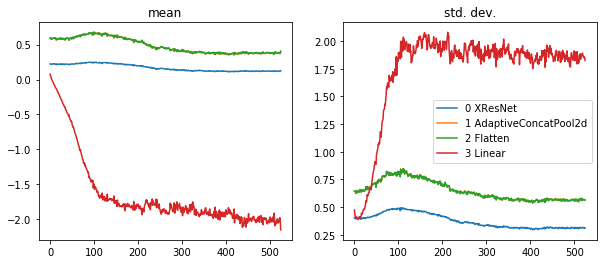

In [90]:
plot_hooks(hooks_naive,fig_name='naive_stats.png',model=learn.model)

In [91]:
type(hooks_naive)

exp.nb_formatted.Hooks

#### Histograms

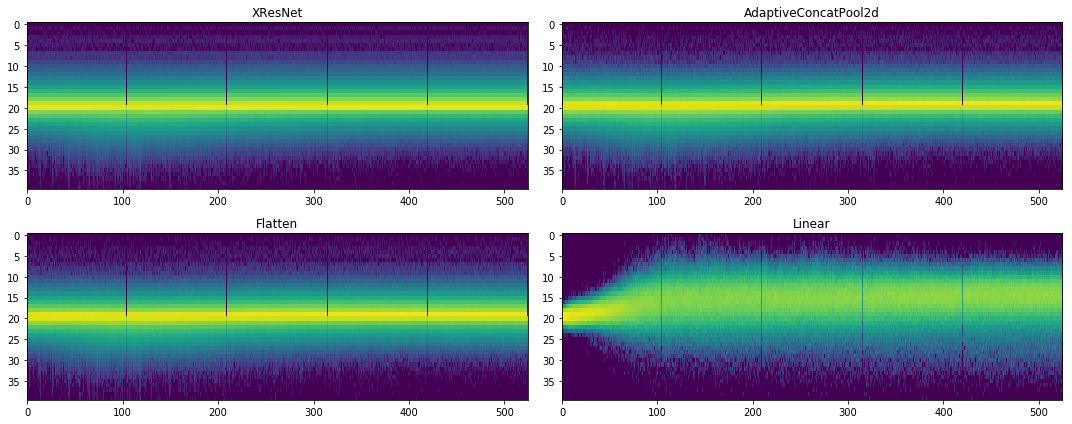

In [92]:
plot_hooks_delta_hist(hooks_naive,fig_name='naive_delta_hists.png',model=learn.model)

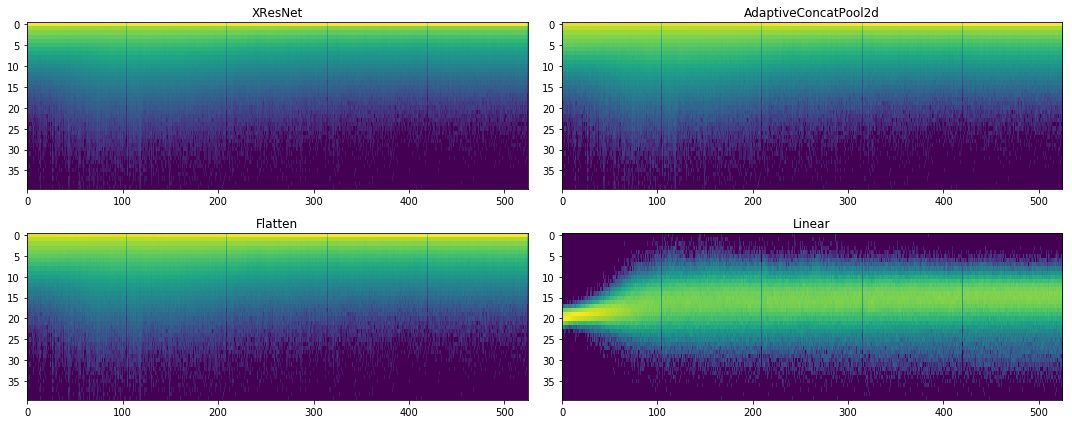

In [93]:
plot_hooks_hist(hooks_naive,fig_name='naive_hists.png',model=learn.model)

In [94]:
#plot_mid_mins(hooks_naive)

In [95]:
def diff_stats(hooks_data):
    histsl=[]
    msl=[]
    ssl=[]
    for h in hooks_data:
        histsl.append(get_hist(h))
        ms,ss, hists = h.stats
        msl.append(ms)
        ssl.append(ss)
    del_ms=np.diff(msl)
    del_ss=np.diff(ssl)
    return del_ms,del_ss

In [96]:
naive_del_ms,naive_del_ss=diff_stats(hooks_naive)

Means change between each layer

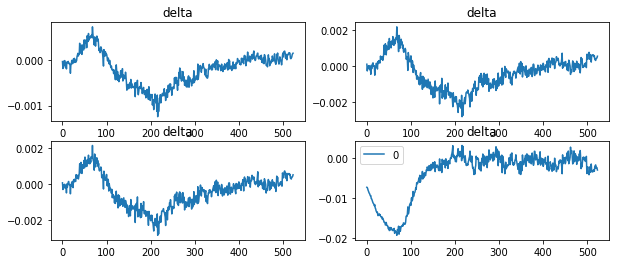

In [97]:
plot_deltas(naive_del_ms, 50,fig_name='naive_del_ms.png')

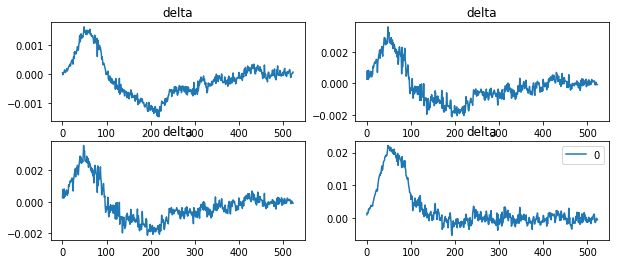

In [98]:
plot_deltas(naive_del_ss, 50,fig_name='naive_del_sds.png')

Means change between first and last layer

2
2


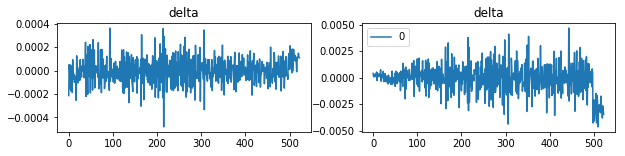

In [99]:
first_n_last = [naive_del_ms[0], naive_del_ms[-1]]
print(len(first_n_last))
naive_del_fal=np.diff(first_n_last)
print(len(naive_del_fal))
plot_deltas(naive_del_fal, 50)

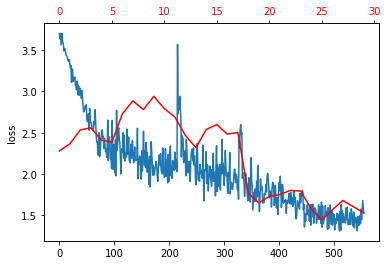

In [100]:
learn.recorder.plot_loss()

In [101]:
len(learn.recorder.losses)/len(learn.recorder.val_losses)

18.5

In [102]:
#18.5 * more training data than validation data 

In [103]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('mst', 11104),
 ('st', 11104),
 ('naive_del_ms', 8496),
 ('naive_del_ss', 8496),
 ('naive_del_fal', 4296),
 ('image_extensions', 2272),
 ('AdaptiveConcatPool2d', 1464),
 ('DataLoader', 1464),
 ('LabelSmoothingCrossEntropy', 1464),
 ('ResBlock', 1464),
 ('master_bar', 1464),
 ('Flatten', 1184),
 ('XResNet', 1184),
 ('AWD_LSTM', 1056),
 ('AverageGrad', 1056),
 ('AverageSqrGrad', 1056),
 ('AvgStats', 1056),
 ('AvgStatsCallback', 1056),
 ('BatchTransformXCallback', 1056),
 ('Beta', 1056),
 ('Callback', 1056),
 ('CancelBatchException', 1056),
 ('CancelEpochException', 1056),
 ('CancelTrainException', 1056),
 ('CategoryProcessor', 1056),
 ('CenterCrop', 1056),
 ('CudaCallback', 1056),
 ('DataBunch', 1056),
 ('Dataset', 1056),
 ('DebugCallback', 1056),
 ('EmbeddingDropout', 1056),
 ('GeneralCrop', 1056),
 ('GeneralRelu', 1056),
 ('GradientClipping', 1056),
 ('Hook', 1056),
 ('Hooks', 1056),
 ('ImageList', 1056),
 ('ItemList', 1056),
 ('Javascript', 1056),
 ('LM_PreLoader', 1056),
 ('LR_Find

In [104]:
#clear mem
naive_del_ms=None
naive_del_ss=None
hooks_naive=None
naive_del_fal=None

## adapt_model and gradual unfreezing

Lines above pasted into one cell to create a function (Shift-M)

In [105]:
def adapt_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        #replace m_cut with children to get data for each layer in XResNet
        *m_cut.children(), AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [106]:
def adapt_deep_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    m_gc = module_grandchildren(m_cut)
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        #replace m_cut with grandchildren to get data for each layer in XResNet
        *m_gc, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [107]:
def adapt_simple_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        m_cut, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [108]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [109]:
if HOOK_DEPTH=='deep':
    adapt_deep_model(learn, data)
elif HOOK_DEPTH=='base':
    adapt_model(learn, data)
elif HOOK_DEPTH=='shallow':
    adapt_simple_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


basic model as per lesson len: 4, with children len: 11, with grandchildren len: 20

In [110]:
len(learn.model); HOOK_DEPTH

'shallow'

Grab all parameters in the body (the m_cut bit) and dont train these - just train the head

#### Freeze everything before head

In [111]:
#everything before AdaptiveConcatPool2d 
for i in range(len(learn.model)-3):
    for p in learn.model[0].parameters(): p.requires_grad_(False)

In [112]:
with Hooks(learn.model, append_hist_delta_stats) as hooks_freeze: 
    learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.887697,0.271636,3.252387,0.305671,00:06
1,2.844618,0.365682,2.692583,0.431535,00:06
2,2.202107,0.504425,2.158732,0.518672,00:06


plotting 4 layers


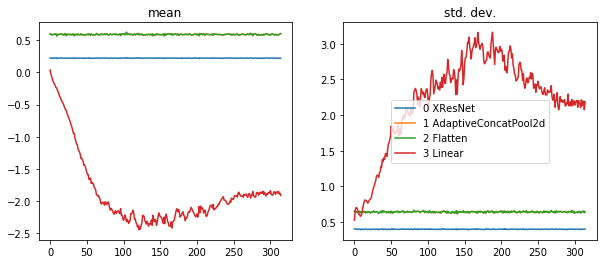

In [113]:
plot_hooks(hooks_freeze,fig_name='freeze_layer_stats.png',model=learn.model)

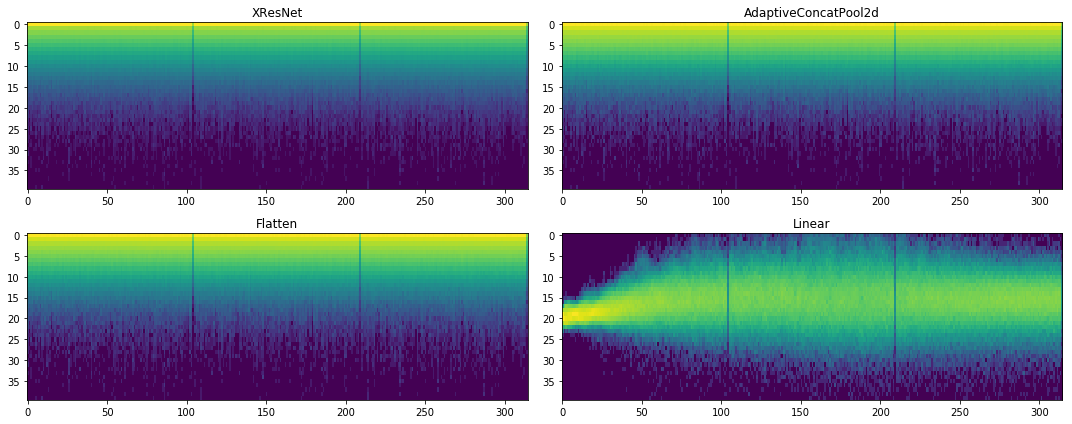

In [114]:
plot_hooks_hist(hooks_freeze,fig_name='freeze_hists.png',model=learn.model)

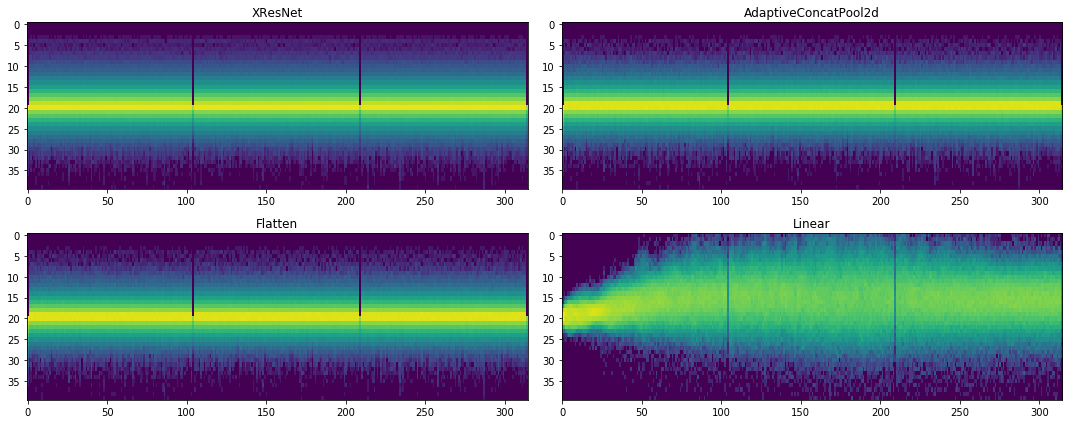

In [115]:
plot_hooks_delta_hist(hooks_freeze,fig_name='freeze_delta_hists.png',model=learn.model)

In [116]:
#plot_mid_mins(hooks_freeze)

In [117]:
frozen_del_ms,frozen_del_ss=diff_stats(hooks_freeze)

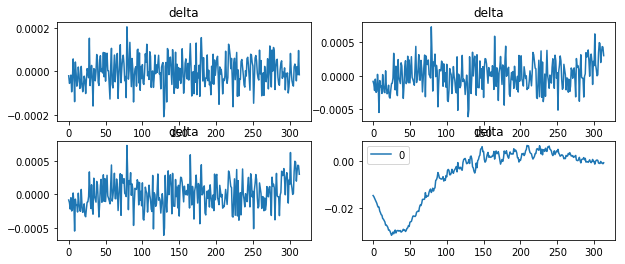

In [118]:
plot_deltas(frozen_del_ms, 50,fig_name='freeze_del_ms.png')

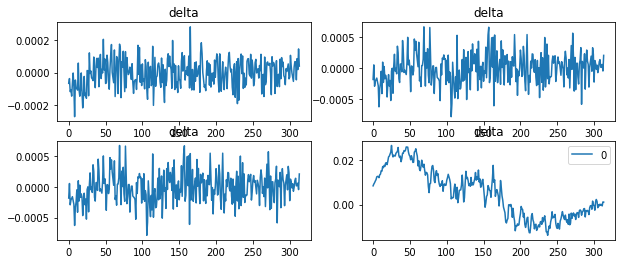

In [119]:
plot_deltas(frozen_del_ss, 50,fig_name='freeze_del_sds.png')

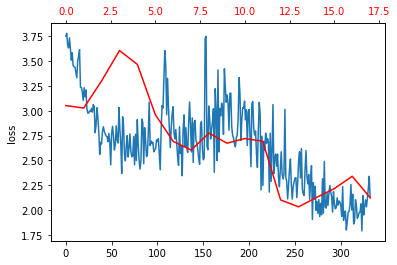

In [120]:
learn.recorder.plot_loss()

In [121]:
#clear mem
frozen_del_ms=None
frozen_del_ss=None
hooks_freeze=None

In [122]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('mst', 11104),
 ('st', 11104),
 ('image_extensions', 2272),
 ('AdaptiveConcatPool2d', 1464),
 ('DataLoader', 1464),
 ('LabelSmoothingCrossEntropy', 1464),
 ('ResBlock', 1464),
 ('master_bar', 1464),
 ('Flatten', 1184),
 ('XResNet', 1184),
 ('AWD_LSTM', 1056),
 ('AverageGrad', 1056),
 ('AverageSqrGrad', 1056),
 ('AvgStats', 1056),
 ('AvgStatsCallback', 1056),
 ('BatchTransformXCallback', 1056),
 ('Beta', 1056),
 ('Callback', 1056),
 ('CancelBatchException', 1056),
 ('CancelEpochException', 1056),
 ('CancelTrainException', 1056),
 ('CategoryProcessor', 1056),
 ('CenterCrop', 1056),
 ('CudaCallback', 1056),
 ('DataBunch', 1056),
 ('Dataset', 1056),
 ('DebugCallback', 1056),
 ('EmbeddingDropout', 1056),
 ('GeneralCrop', 1056),
 ('GeneralRelu', 1056),
 ('GradientClipping', 1056),
 ('Hook', 1056),
 ('Hooks', 1056),
 ('ImageList', 1056),
 ('ItemList', 1056),
 ('Javascript', 1056),
 ('LM_PreLoader', 1056),
 ('LR_Find', 1056),
 ('LabeledData', 1056),
 ('Lambda', 1056),
 ('LinearDecoder', 1056

#### Unfreeze

In [123]:
#everything before AdaptiveConcatPool2d - note difference to lesson nb where just have layer 0
for i in range(len(learn.model)-3):
    for p in learn.model[i].parameters(): p.requires_grad_(True)

In [124]:
with Hooks(learn.model, append_hist_delta_stats) as hooks_unfreeze: 
    learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.912322,0.582271,2.095840,0.528354,00:09
1,1.959055,0.555272,2.563144,0.401107,00:09
2,1.959851,0.556322,2.378253,0.417704,00:09
3,1.698510,0.650517,1.861952,0.589212,00:09
4,1.430908,0.762112,1.606515,0.679115,00:09



In frozen layer - train for particuar mean and std dev, but pets has different std dev and means inside the model.

What is really going on here? (1:26 in lesson video), and why do I get better results when JH got worse result?

plotting 4 layers


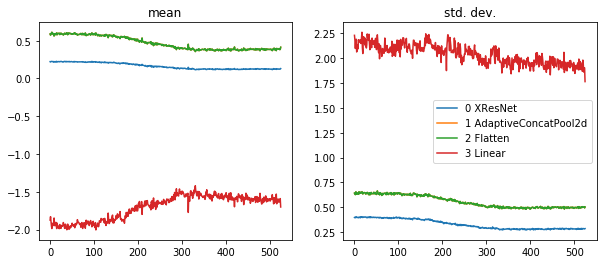

In [125]:
plot_hooks(hooks_unfreeze,fig_name='unfreeze_layer_stats.png',model=learn.model)

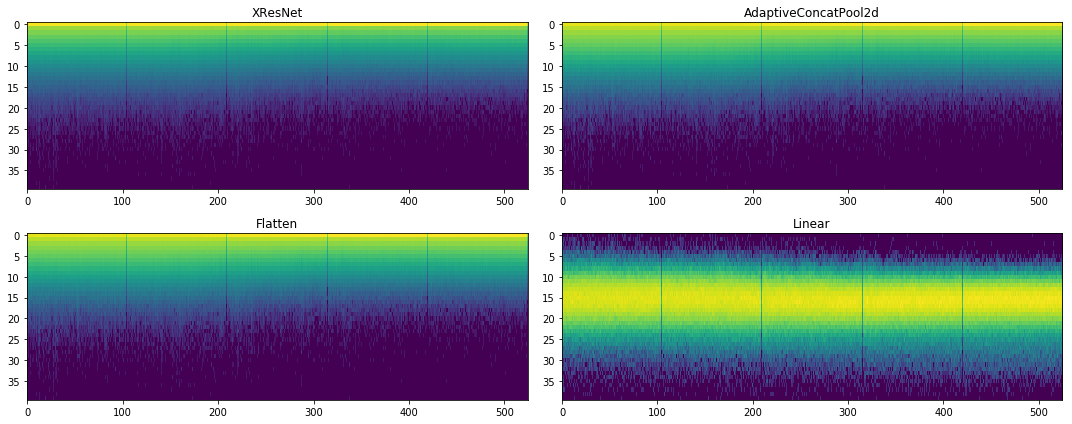

In [126]:
plot_hooks_hist(hooks_unfreeze,fig_name='unfreeze_hists.png',model=learn.model)

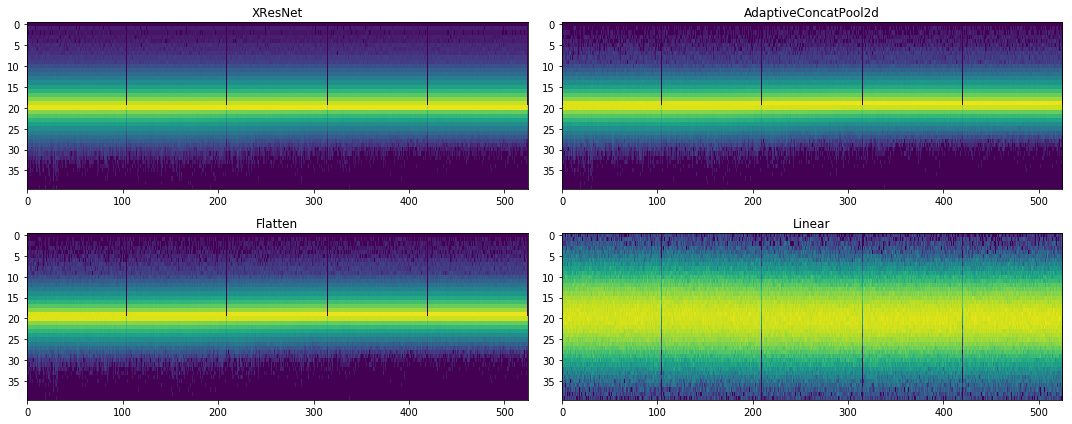

In [127]:
plot_hooks_delta_hist(hooks_unfreeze,fig_name='unfreeze_delta_hists.png',model=learn.model)

In [128]:
#plot_mid_mins(hooks_unfreeze)

In [129]:
unfrozen_del_ms,unfrozen_del_ss=diff_stats(hooks_unfreeze)

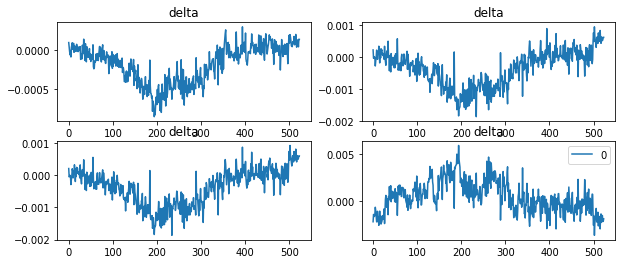

In [130]:
plot_deltas(unfrozen_del_ms, 50,fig_name='unfreeze_del_ms.png')

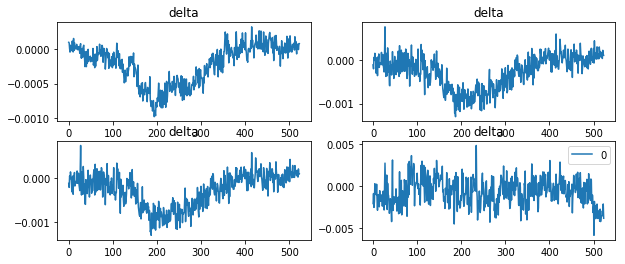

In [131]:
plot_deltas(unfrozen_del_ss, 50,fig_name='unfreeze_del_sds.png')

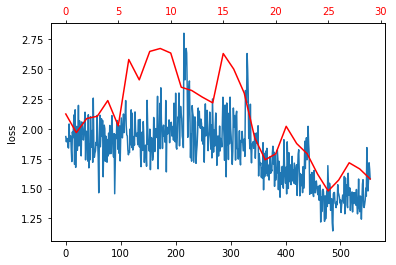

In [132]:
learn.recorder.plot_loss()

Freeze only layer params that aren't in the batch norm layers

1:27 in lesson 12

In [133]:
#clear mem
unfrozen_del_ms=None
unfrozen_del_ss=None
hooks_unfreeze=None

In [134]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('mst', 11104),
 ('st', 11104),
 ('image_extensions', 2272),
 ('AdaptiveConcatPool2d', 1464),
 ('DataLoader', 1464),
 ('LabelSmoothingCrossEntropy', 1464),
 ('ResBlock', 1464),
 ('master_bar', 1464),
 ('Flatten', 1184),
 ('XResNet', 1184),
 ('AWD_LSTM', 1056),
 ('AverageGrad', 1056),
 ('AverageSqrGrad', 1056),
 ('AvgStats', 1056),
 ('AvgStatsCallback', 1056),
 ('BatchTransformXCallback', 1056),
 ('Beta', 1056),
 ('Callback', 1056),
 ('CancelBatchException', 1056),
 ('CancelEpochException', 1056),
 ('CancelTrainException', 1056),
 ('CategoryProcessor', 1056),
 ('CenterCrop', 1056),
 ('CudaCallback', 1056),
 ('DataBunch', 1056),
 ('Dataset', 1056),
 ('DebugCallback', 1056),
 ('EmbeddingDropout', 1056),
 ('GeneralCrop', 1056),
 ('GeneralRelu', 1056),
 ('GradientClipping', 1056),
 ('Hook', 1056),
 ('Hooks', 1056),
 ('ImageList', 1056),
 ('ItemList', 1056),
 ('Javascript', 1056),
 ('LM_PreLoader', 1056),
 ('LR_Find', 1056),
 ('LabeledData', 1056),
 ('Lambda', 1056),
 ('LinearDecoder', 1056

## Batch norm transfer

Freeze all params that are not in the batchnorm layer or linear layer at end

In [135]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [136]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    #if linear layer (at end) or batchnorm layer in middle, dont change the gradient
    print(type(m))
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

#### Freeze and fit

Freeze just non batchnorm and last layer, note using apply_mod we traverse children layers so can access Batchnorm layers inside sequential

In [137]:
apply_mod(learn.model, partial(set_grad, b=False))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'exp.nb_formatted.ResBlock'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'tor

In [138]:
#run out of mem with deltas
with Hooks(learn.model, append_hist_stats) as hooks_freeze_non_bn: 
    learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.770316,0.295485,2.569231,0.390042,00:29
1,2.254562,0.446078,2.055562,0.532503,00:29
2,1.942387,0.563522,1.919271,0.573997,00:29


plotting 11 layers


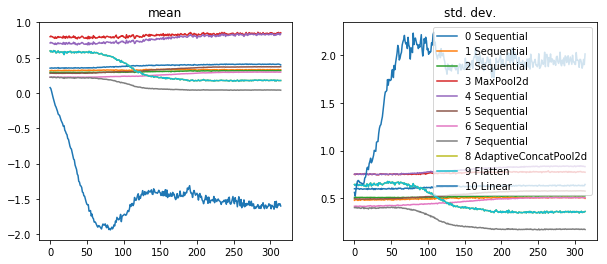

In [139]:
plot_hooks(hooks_freeze_non_bn,fig_name='freeze_non_bn_layers.png',model=learn.model)

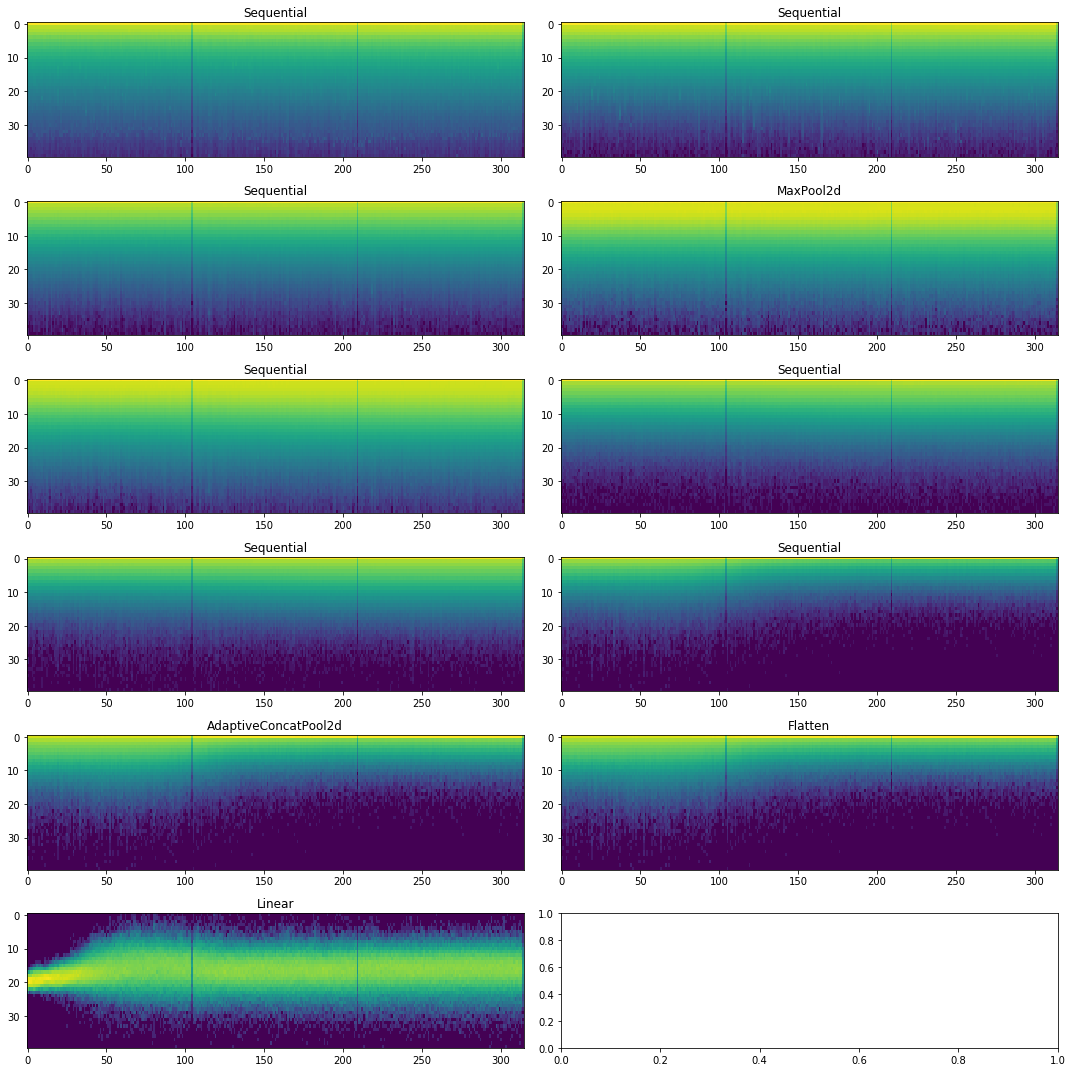

In [140]:
plot_hooks_hist(hooks_freeze_non_bn,fig_name='freeze_non_bn_hist.png',model=learn.model)

In [141]:
#plot_hooks_delta_hist(hooks_freeze_non_bn,fig_name='freeze_non_bn_delta_hist.png',model=learn.model)

In [142]:
#plot_mins(hooks_freeze_non_bn)

In [143]:
freeze_non_bn_del_ms,freeze_non_bn_del_sds=diff_stats(hooks_freeze_non_bn)

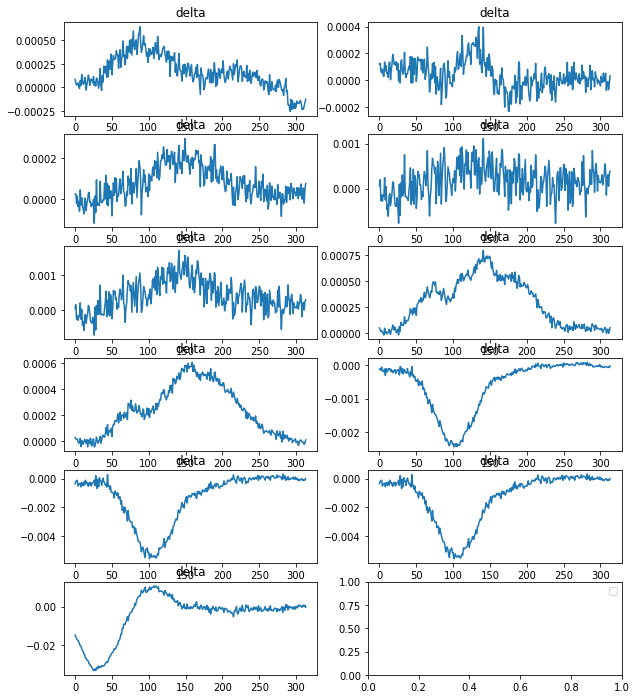

In [144]:
plot_deltas(freeze_non_bn_del_ms, 50,fig_name='freeze_non_bn_del_ms.png')

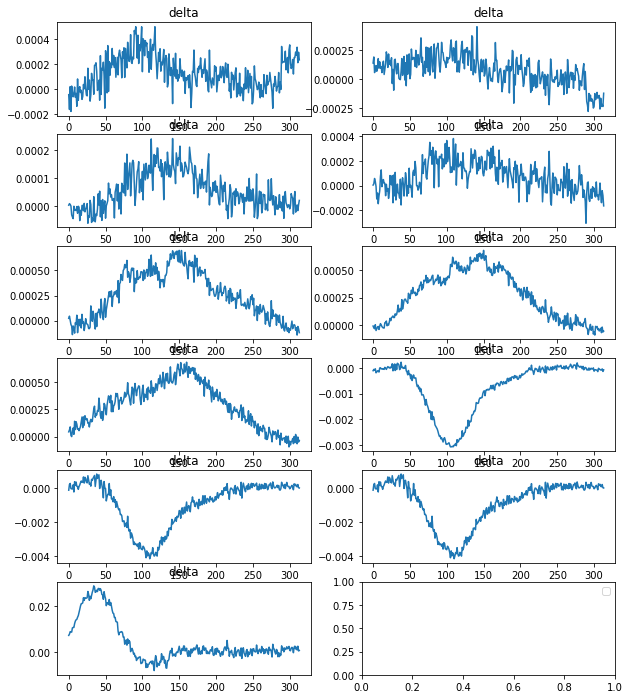

In [145]:
plot_deltas(freeze_non_bn_del_sds, 50,fig_name='freeze_non_bn_del_sds.png')

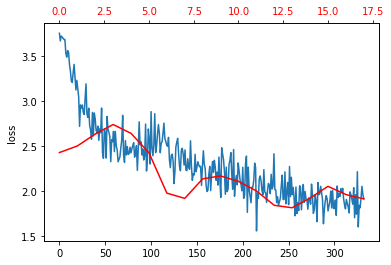

In [146]:
learn.recorder.plot_loss()

#### Unfreeze

In [147]:
apply_mod(learn.model, partial(set_grad, b=True))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'exp.nb_formatted.ResBlock'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'tor

In [148]:
with Hooks(learn.model, append_hist_stats) as hooks_unfreeze_non_bn: 
    learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.826556,0.601470,2.029022,0.554633,00:31
1,1.859626,0.588121,2.434390,0.416321,00:32
2,1.857017,0.586921,2.039212,0.547718,00:32
3,1.668896,0.661767,1.712742,0.630705,00:32
4,1.425542,0.767062,1.575639,0.684647,00:32


plotting 11 layers


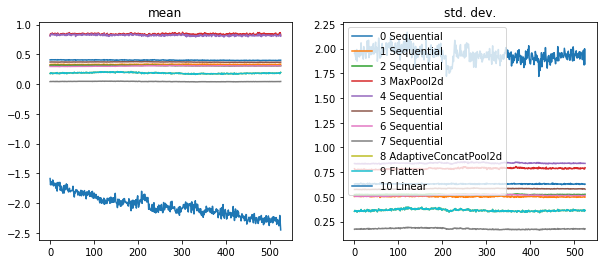

In [149]:
plot_hooks(hooks_unfreeze_non_bn,fig_name='unfreeze_non_bn_layers.png',model=learn.model)

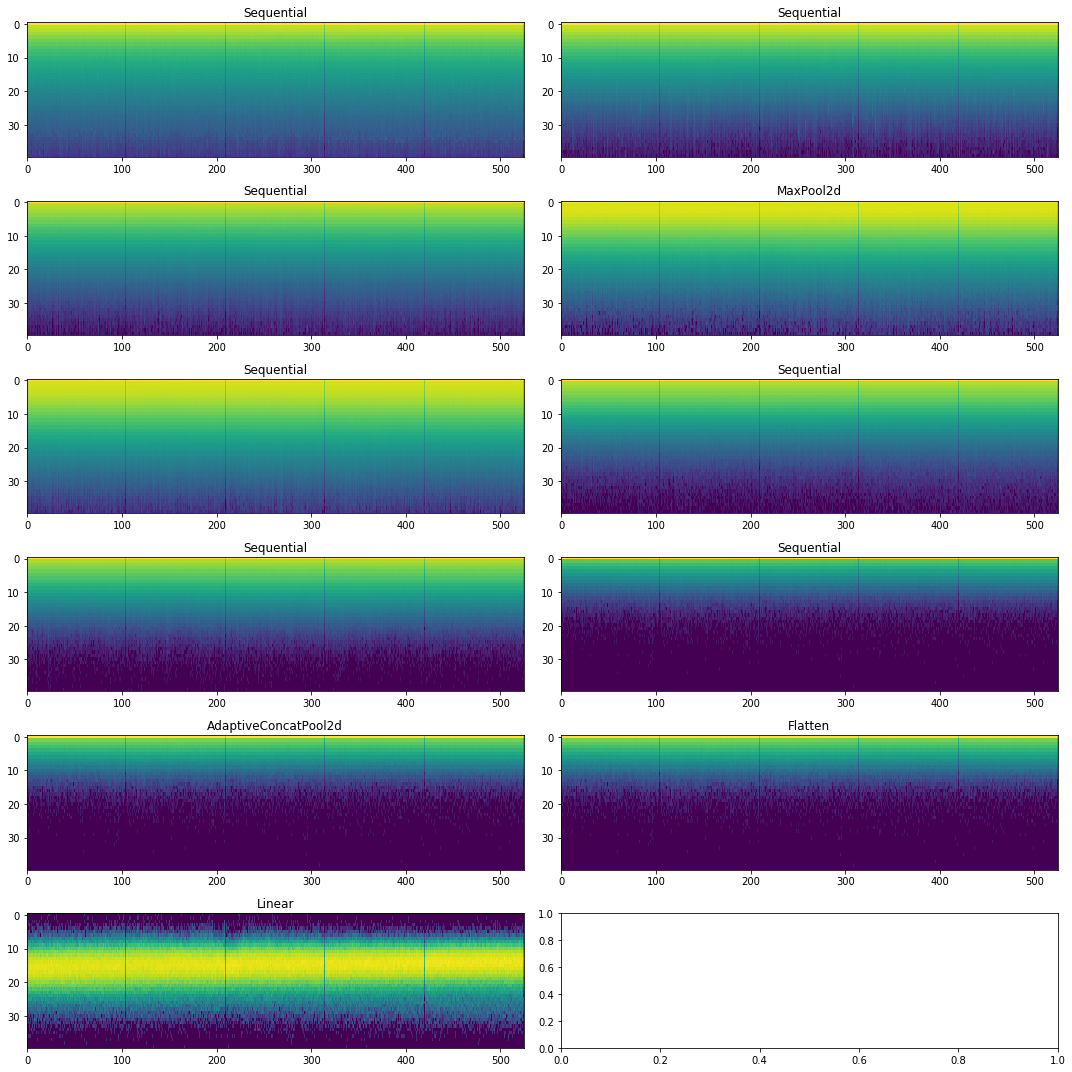

In [150]:
plot_hooks_hist(hooks_unfreeze_non_bn,fig_name='unfreeze_non_bn_hist.png',model=learn.model)

In [151]:
#plot_hooks_delta_hist(hooks_unfreeze_non_bn,fig_name='unfreeze_non_bn_delta_hist.png',model=learn.model)

In [152]:
#plot_mins(hooks_unfreeze_non_bn)

In [153]:
unfreeze_non_bn_del_ms,unfreeze_non_bn_del_sds=diff_stats(hooks_unfreeze_non_bn)

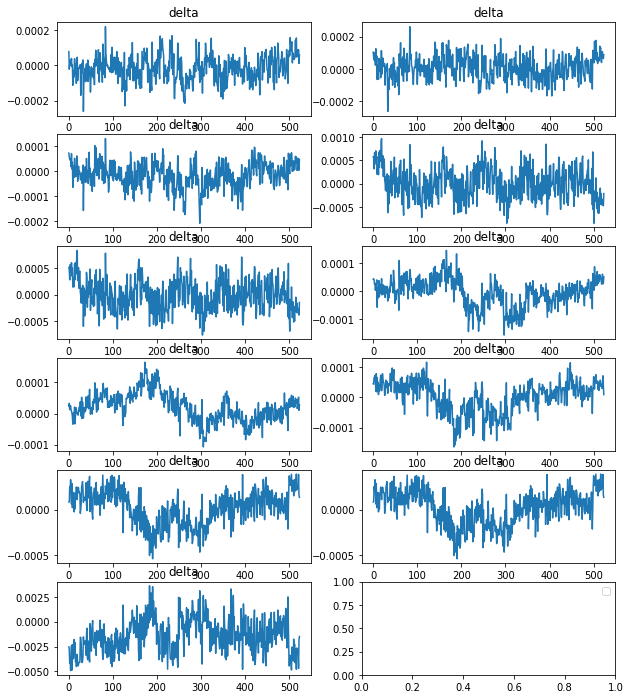

In [154]:
plot_deltas(unfreeze_non_bn_del_ms, 50,fig_name='unfreeze_non_bn_del_ms.png')

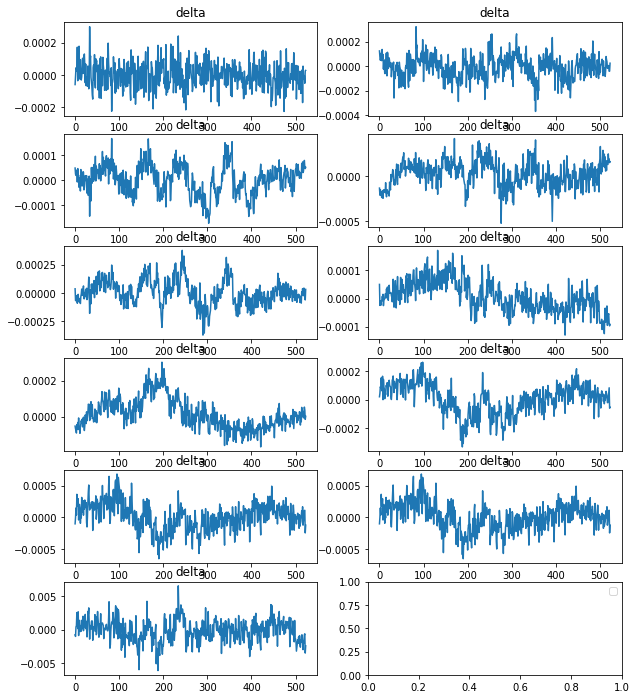

In [155]:
plot_deltas(unfreeze_non_bn_del_sds, 50,fig_name='unfreeze_non_bn_del_sds.png')

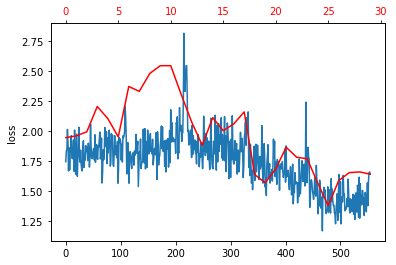

In [156]:
learn.recorder.plot_loss()

Pytorch already has an `apply` method we can use:

In [157]:
learn.model.apply(partial(set_grad, b=False));

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'exp.nb_formatted.ResBlock'>
<class 'torch.nn.mo

Lesson 12 video: 1:29

## Discriminative LR and param groups

In [158]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [159]:
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [160]:
len(learn.model)

11

In [161]:
adapt_simple_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [162]:
len(learn.model)

4

In [163]:
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): 
            g2 += l.parameters()
        elif hasattr(l, 'weight'): 
            g1 += l.parameters()
        for ll in l.children(): 
            _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

In [164]:
m = learn.model

In [165]:
a,b = bn_splitter(m)

In [166]:
len(a)

22

In [167]:
len(list(m.parameters()))

68

In [168]:
test_eq(len(a)+len(b), len(list(m.parameters())))

In [169]:
Learner.ALL_CBS

{'after_backward',
 'after_batch',
 'after_cancel_batch',
 'after_cancel_epoch',
 'after_cancel_train',
 'after_epoch',
 'after_fit',
 'after_loss',
 'after_pred',
 'after_step',
 'begin_batch',
 'begin_epoch',
 'begin_fit',
 'begin_validate'}

In [170]:
#export
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CBS})

In [171]:
cb_types.after_backward

'after_backward'

In [172]:
#export
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name,self.f = cb_name,f
    def __call__(self, cb_name):
        if cb_name==self.cb_name:
            if self.f: self.f(self.run)
            else:      set_trace()

In [173]:
#export
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [174]:
disc_lr_sched = sched_1cycle([0,3e-2], 0.5)

In [175]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func,
                    c_out=10, norm=norm_imagenette, splitter=bn_splitter)

learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [176]:
def _print_det(o): 
    print (len(o.opt.param_groups), o.opt.hypers)
    raise CancelTrainException()

learn.fit(1, disc_lr_sched + [DebugCallback(cb_types.after_batch, _print_det)])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


2 [{'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0, 'sqr_mom': 0.99}, {'mom': 0.9499999999999997, 'mom_sqr': 0.99, 'eps': 1e-06, 'wd': 0.01, 'lr': 0.0030000000000000512, 'sqr_mom': 0.99}]


In [177]:
learn.fit(3, disc_lr_sched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.887967,0.260987,3.751006,0.110650,00:07
1,2.806778,0.266537,2.788442,0.278008,00:07
2,2.305888,0.433478,2.095287,0.491010,00:07


In [178]:
disc_lr_sched = sched_1cycle([1e-3,1e-2], 0.3)

In [179]:
learn.fit(5, disc_lr_sched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.004972,0.530973,2.350271,0.430152,00:07
1,2.078756,0.500675,2.464891,0.409405,00:07
2,1.970601,0.545823,2.045761,0.493776,00:07
3,1.760420,0.617669,1.765404,0.621024,00:07
4,1.614209,0.677666,1.724041,0.643154,00:07


## Export

In [180]:
#!./notebook2script.py 11a_transfer_learning.ipynb